In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 937)
(631390, 1)
validation
(74368, 937)
(74368, 1)
test
(85358, 937)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 937)]             0         


 dense (Dense)               (None, 1024)              960512    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1649665 (6.29 MB)


Trainable params: 1649665 (6.29 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:34 - loss: 0.2018 - STD: 1.4438e-04 - MAE: 0.4379

 4/64 [>.............................] - ETA: 1s - loss: 0.0696 - STD: 3.1714e-04 - MAE: 0.2052  

 7/64 [==>...........................] - ETA: 1s - loss: 0.0487 - STD: 2.2059e-04 - MAE: 0.1644

 8/64 [==>...........................] - ETA: 5s - loss: 0.0483 - STD: 1.9697e-04 - MAE: 0.1600

11/64 [====>.........................] - ETA: 4s - loss: 0.0422 - STD: 1.4735e-04 - MAE: 0.1532

14/64 [=====>........................] - ETA: 3s - loss: 0.0389 - STD: 1.1688e-04 - MAE: 0.1492

17/64 [======>.......................] - ETA: 2s - loss: 0.0364 - STD: 9.7812e-05 - MAE: 0.1452

20/64 [========>.....................] - ETA: 2s - loss: 0.0340 - STD: 8.5625e-05 - MAE: 0.1403

23/64 [=========>....................] - ETA: 2s - loss: 0.0316 - STD: 7.7511e-05 - MAE: 0.1341

26/64 [===========>..................] - ETA: 1s - loss: 0.0293 - STD: 7.1772e-05 - MAE: 0.1278

29/64 [============>.................] - ETA: 1s - loss: 0.0272 - STD: 6.7324e-05 - MAE: 0.1228

32/64 [==============>...............] - ETA: 1s - loss: 0.0257 - STD: 6.3560e-05 - MAE: 0.1198

35/64 [===============>..............] - ETA: 1s - loss: 0.0245 - STD: 6.0053e-05 - MAE: 0.1176

38/64 [================>.............] - ETA: 1s - loss: 0.0234 - STD: 5.6681e-05 - MAE: 0.1151

41/64 [==================>...........] - ETA: 0s - loss: 0.0224 - STD: 5.3512e-05 - MAE: 0.1124

44/64 [===================>..........] - ETA: 0s - loss: 0.0216 - STD: 5.0621e-05 - MAE: 0.1100

47/64 [=====================>........] - ETA: 0s - loss: 0.0209 - STD: 4.8040e-05 - MAE: 0.1078

50/64 [======================>.......] - ETA: 0s - loss: 0.0202 - STD: 4.5761e-05 - MAE: 0.1059

53/64 [=======================>......] - ETA: 0s - loss: 0.0196 - STD: 4.3763e-05 - MAE: 0.1042

56/64 [=========================>....] - ETA: 0s - loss: 0.0191 - STD: 4.2009e-05 - MAE: 0.1028

59/64 [==========================>...] - ETA: 0s - loss: 0.0186 - STD: 4.0456e-05 - MAE: 0.1017

62/64 [============================>.] - ETA: 0s - loss: 0.0182 - STD: 3.9061e-05 - MAE: 0.1006

64/64 [==============================] - 4s 45ms/step - loss: 0.0180 - STD: 3.8203e-05 - MAE: 0.1000 - val_loss: 0.0095 - val_STD: 9.6860e-06 - val_MAE: 0.0778


Epoch 2/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0098 - STD: 1.1465e-05 - MAE: 0.0786

 3/64 [>.............................] - ETA: 1s - loss: 0.0098 - STD: 1.1526e-05 - MAE: 0.0785

 6/64 [=>............................] - ETA: 1s - loss: 0.0099 - STD: 1.1409e-05 - MAE: 0.0783

 9/64 [===>..........................] - ETA: 1s - loss: 0.0099 - STD: 1.1391e-05 - MAE: 0.0776

12/64 [====>.........................] - ETA: 1s - loss: 0.0099 - STD: 1.1423e-05 - MAE: 0.0774

15/64 [======>.......................] - ETA: 1s - loss: 0.0099 - STD: 1.1519e-05 - MAE: 0.0773

18/64 [=======>......................] - ETA: 1s - loss: 0.0099 - STD: 1.1670e-05 - MAE: 0.0774

21/64 [========>.....................] - ETA: 1s - loss: 0.0099 - STD: 1.1818e-05 - MAE: 0.0775

24/64 [==========>...................] - ETA: 0s - loss: 0.0099 - STD: 1.1990e-05 - MAE: 0.0777

27/64 [===========>..................] - ETA: 0s - loss: 0.0099 - STD: 1.2150e-05 - MAE: 0.0777

30/64 [=============>................] - ETA: 0s - loss: 0.0099 - STD: 1.2317e-05 - MAE: 0.0777

33/64 [==============>...............] - ETA: 0s - loss: 0.0099 - STD: 1.2473e-05 - MAE: 0.0777

36/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 1.2637e-05 - MAE: 0.0778

39/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 1.2806e-05 - MAE: 0.0777

42/64 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 1.2996e-05 - MAE: 0.0778

45/64 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 1.3195e-05 - MAE: 0.0778

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.3411e-05 - MAE: 0.0778

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.3628e-05 - MAE: 0.0778

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.3843e-05 - MAE: 0.0778

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.4070e-05 - MAE: 0.0778

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.4316e-05 - MAE: 0.0778

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.4567e-05 - MAE: 0.0778

64/64 [==============================] - 2s 27ms/step - loss: 0.0099 - STD: 1.4652e-05 - MAE: 0.0778 - val_loss: 0.0094 - val_STD: 1.5794e-05 - val_MAE: 0.0767


Epoch 3/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0100 - STD: 2.0320e-05 - MAE: 0.0781

 4/64 [>.............................] - ETA: 1s - loss: 0.0100 - STD: 2.0668e-05 - MAE: 0.0785

 7/64 [==>...........................] - ETA: 1s - loss: 0.0099 - STD: 2.1138e-05 - MAE: 0.0783

10/64 [===>..........................] - ETA: 1s - loss: 0.0099 - STD: 2.1475e-05 - MAE: 0.0781

13/64 [=====>........................] - ETA: 1s - loss: 0.0099 - STD: 2.1856e-05 - MAE: 0.0780

16/64 [======>.......................] - ETA: 1s - loss: 0.0099 - STD: 2.2286e-05 - MAE: 0.0779

19/64 [=======>......................] - ETA: 1s - loss: 0.0099 - STD: 2.2750e-05 - MAE: 0.0779

22/64 [=========>....................] - ETA: 1s - loss: 0.0099 - STD: 2.3206e-05 - MAE: 0.0779

25/64 [==========>...................] - ETA: 0s - loss: 0.0099 - STD: 2.3695e-05 - MAE: 0.0779

28/64 [============>.................] - ETA: 0s - loss: 0.0099 - STD: 2.4208e-05 - MAE: 0.0779

31/64 [=============>................] - ETA: 0s - loss: 0.0099 - STD: 2.4736e-05 - MAE: 0.0778

34/64 [==============>...............] - ETA: 0s - loss: 0.0099 - STD: 2.5276e-05 - MAE: 0.0778

37/64 [================>.............] - ETA: 0s - loss: 0.0099 - STD: 2.5830e-05 - MAE: 0.0778

40/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 2.6438e-05 - MAE: 0.0778

43/64 [===================>..........] - ETA: 0s - loss: 0.0099 - STD: 2.7080e-05 - MAE: 0.0779

46/64 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 2.7750e-05 - MAE: 0.0779

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 2.8457e-05 - MAE: 0.0780

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 2.9176e-05 - MAE: 0.0780

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.9921e-05 - MAE: 0.0780

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 3.0681e-05 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 3.1511e-05 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 3.2386e-05 - MAE: 0.0779

64/64 [==============================] - 2s 27ms/step - loss: 0.0099 - STD: 3.2386e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 3.8390e-05 - val_MAE: 0.0765


Epoch 4/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0098 - STD: 5.1385e-05 - MAE: 0.0772

 3/64 [>.............................] - ETA: 1s - loss: 0.0098 - STD: 5.2526e-05 - MAE: 0.0774

 6/64 [=>............................] - ETA: 1s - loss: 0.0099 - STD: 5.4320e-05 - MAE: 0.0779

 9/64 [===>..........................] - ETA: 1s - loss: 0.0099 - STD: 5.5858e-05 - MAE: 0.0779

12/64 [====>.........................] - ETA: 1s - loss: 0.0099 - STD: 5.7398e-05 - MAE: 0.0778

15/64 [======>.......................] - ETA: 1s - loss: 0.0099 - STD: 5.9139e-05 - MAE: 0.0779

18/64 [=======>......................] - ETA: 1s - loss: 0.0099 - STD: 6.0850e-05 - MAE: 0.0778

21/64 [========>.....................] - ETA: 1s - loss: 0.0099 - STD: 6.2807e-05 - MAE: 0.0778

24/64 [==========>...................] - ETA: 0s - loss: 0.0099 - STD: 6.4849e-05 - MAE: 0.0778

27/64 [===========>..................] - ETA: 0s - loss: 0.0099 - STD: 6.6995e-05 - MAE: 0.0778

30/64 [=============>................] - ETA: 0s - loss: 0.0099 - STD: 6.9261e-05 - MAE: 0.0779

33/64 [==============>...............] - ETA: 0s - loss: 0.0099 - STD: 7.1766e-05 - MAE: 0.0778

36/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 7.4377e-05 - MAE: 0.0778

39/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 7.7183e-05 - MAE: 0.0778

42/64 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 8.0202e-05 - MAE: 0.0778

45/64 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 8.3409e-05 - MAE: 0.0778

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 8.6848e-05 - MAE: 0.0778

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 9.0615e-05 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 9.4638e-05 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 9.7504e-05 - MAE: 0.0779

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.0200e-04 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.0517e-04 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 1.1038e-04 - MAE: 0.0778

64/64 [==============================] - 2s 27ms/step - loss: 0.0099 - STD: 1.1038e-04 - MAE: 0.0778 - val_loss: 0.0094 - val_STD: 1.6594e-04 - val_MAE: 0.0763


Epoch 5/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0099 - STD: 2.2906e-04 - MAE: 0.0778

 4/64 [>.............................] - ETA: 1s - loss: 0.0100 - STD: 2.4029e-04 - MAE: 0.0775

 7/64 [==>...........................] - ETA: 1s - loss: 0.0099 - STD: 2.5197e-04 - MAE: 0.0776

 9/64 [===>..........................] - ETA: 1s - loss: 0.0099 - STD: 2.6039e-04 - MAE: 0.0776

12/64 [====>.........................] - ETA: 1s - loss: 0.0099 - STD: 2.7403e-04 - MAE: 0.0777

15/64 [======>.......................] - ETA: 1s - loss: 0.0099 - STD: 2.8911e-04 - MAE: 0.0777

18/64 [=======>......................] - ETA: 1s - loss: 0.0099 - STD: 3.0533e-04 - MAE: 0.0778

21/64 [========>.....................] - ETA: 1s - loss: 0.0099 - STD: 3.2442e-04 - MAE: 0.0778

24/64 [==========>...................] - ETA: 0s - loss: 0.0099 - STD: 3.4494e-04 - MAE: 0.0778

27/64 [===========>..................] - ETA: 0s - loss: 0.0099 - STD: 3.6731e-04 - MAE: 0.0778

30/64 [=============>................] - ETA: 0s - loss: 0.0099 - STD: 3.9141e-04 - MAE: 0.0778

33/64 [==============>...............] - ETA: 0s - loss: 0.0099 - STD: 4.1775e-04 - MAE: 0.0777

36/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 4.4716e-04 - MAE: 0.0777

39/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 4.7976e-04 - MAE: 0.0777

42/64 [==================>...........] - ETA: 0s - loss: 0.0098 - STD: 5.1515e-04 - MAE: 0.0776

45/64 [====================>.........] - ETA: 0s - loss: 0.0098 - STD: 5.5428e-04 - MAE: 0.0776

48/64 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 5.9778e-04 - MAE: 0.0776

51/64 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 6.4628e-04 - MAE: 0.0776

54/64 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 7.0020e-04 - MAE: 0.0776

57/64 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 7.6093e-04 - MAE: 0.0776

60/64 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 8.2893e-04 - MAE: 0.0776

63/64 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 9.0554e-04 - MAE: 0.0776

64/64 [==============================] - 2s 27ms/step - loss: 0.0098 - STD: 9.3298e-04 - MAE: 0.0776 - val_loss: 0.0092 - val_STD: 0.0020 - val_MAE: 0.0757


Epoch 6/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0096 - STD: 0.0028 - MAE: 0.0773

 3/64 [>.............................] - ETA: 1s - loss: 0.0096 - STD: 0.0029 - MAE: 0.0769

 6/64 [=>............................] - ETA: 1s - loss: 0.0095 - STD: 0.0032 - MAE: 0.0768

 8/64 [==>...........................] - ETA: 1s - loss: 0.0096 - STD: 0.0033 - MAE: 0.0768

11/64 [====>.........................] - ETA: 1s - loss: 0.0096 - STD: 0.0036 - MAE: 0.0768

14/64 [=====>........................] - ETA: 1s - loss: 0.0096 - STD: 0.0039 - MAE: 0.0767

17/64 [======>.......................] - ETA: 1s - loss: 0.0095 - STD: 0.0042 - MAE: 0.0766

20/64 [========>.....................] - ETA: 1s - loss: 0.0095 - STD: 0.0046 - MAE: 0.0765

23/64 [=========>....................] - ETA: 1s - loss: 0.0095 - STD: 0.0050 - MAE: 0.0764

26/64 [===========>..................] - ETA: 0s - loss: 0.0095 - STD: 0.0055 - MAE: 0.0764

29/64 [============>.................] - ETA: 0s - loss: 0.0094 - STD: 0.0060 - MAE: 0.0763

32/64 [==============>...............] - ETA: 0s - loss: 0.0094 - STD: 0.0065 - MAE: 0.0761

35/64 [===============>..............] - ETA: 0s - loss: 0.0093 - STD: 0.0071 - MAE: 0.0759

38/64 [================>.............] - ETA: 0s - loss: 0.0093 - STD: 0.0078 - MAE: 0.0757

41/64 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 0.0085 - MAE: 0.0755

44/64 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 0.0092 - MAE: 0.0753

47/64 [=====================>........] - ETA: 0s - loss: 0.0091 - STD: 0.0100 - MAE: 0.0751

50/64 [======================>.......] - ETA: 0s - loss: 0.0091 - STD: 0.0109 - MAE: 0.0749

53/64 [=======================>......] - ETA: 0s - loss: 0.0090 - STD: 0.0118 - MAE: 0.0746

56/64 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.0126 - MAE: 0.0744

59/64 [==========================>...] - ETA: 0s - loss: 0.0089 - STD: 0.0135 - MAE: 0.0742

62/64 [============================>.] - ETA: 0s - loss: 0.0089 - STD: 0.0145 - MAE: 0.0739

64/64 [==============================] - 2s 28ms/step - loss: 0.0088 - STD: 0.0151 - MAE: 0.0738 - val_loss: 0.0072 - val_STD: 0.0235 - val_MAE: 0.0670


Epoch 7/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0078 - STD: 0.0354 - MAE: 0.0685

 3/64 [>.............................] - ETA: 1s - loss: 0.0077 - STD: 0.0358 - MAE: 0.0678

 6/64 [=>............................] - ETA: 1s - loss: 0.0076 - STD: 0.0364 - MAE: 0.0677

 9/64 [===>..........................] - ETA: 1s - loss: 0.0075 - STD: 0.0370 - MAE: 0.0673

12/64 [====>.........................] - ETA: 1s - loss: 0.0074 - STD: 0.0378 - MAE: 0.0669

15/64 [======>.......................] - ETA: 1s - loss: 0.0074 - STD: 0.0386 - MAE: 0.0664

18/64 [=======>......................] - ETA: 1s - loss: 0.0073 - STD: 0.0394 - MAE: 0.0660

21/64 [========>.....................] - ETA: 1s - loss: 0.0072 - STD: 0.0402 - MAE: 0.0657

24/64 [==========>...................] - ETA: 0s - loss: 0.0071 - STD: 0.0411 - MAE: 0.0653

27/64 [===========>..................] - ETA: 0s - loss: 0.0071 - STD: 0.0420 - MAE: 0.0649

30/64 [=============>................] - ETA: 0s - loss: 0.0070 - STD: 0.0429 - MAE: 0.0646

33/64 [==============>...............] - ETA: 0s - loss: 0.0069 - STD: 0.0439 - MAE: 0.0642

36/64 [===============>..............] - ETA: 0s - loss: 0.0068 - STD: 0.0447 - MAE: 0.0638

39/64 [=================>............] - ETA: 0s - loss: 0.0068 - STD: 0.0455 - MAE: 0.0635

42/64 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0461 - MAE: 0.0632

45/64 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0468 - MAE: 0.0629

48/64 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0475 - MAE: 0.0627

51/64 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0481 - MAE: 0.0625

54/64 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0487 - MAE: 0.0623

57/64 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0493 - MAE: 0.0621

60/64 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0498 - MAE: 0.0618

63/64 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0503 - MAE: 0.0617

64/64 [==============================] - 2s 27ms/step - loss: 0.0064 - STD: 0.0504 - MAE: 0.0616 - val_loss: 0.0051 - val_STD: 0.0545 - val_MAE: 0.0568


Epoch 8/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0057 - STD: 0.0622 - MAE: 0.0590

 4/64 [>.............................] - ETA: 1s - loss: 0.0058 - STD: 0.0592 - MAE: 0.0579

 7/64 [==>...........................] - ETA: 1s - loss: 0.0058 - STD: 0.0595 - MAE: 0.0582

10/64 [===>..........................] - ETA: 1s - loss: 0.0058 - STD: 0.0600 - MAE: 0.0581

13/64 [=====>........................] - ETA: 1s - loss: 0.0057 - STD: 0.0599 - MAE: 0.0579

16/64 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0599 - MAE: 0.0576

19/64 [=======>......................] - ETA: 1s - loss: 0.0057 - STD: 0.0601 - MAE: 0.0575

22/64 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0604 - MAE: 0.0574

25/64 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0606 - MAE: 0.0573

28/64 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0606 - MAE: 0.0572

31/64 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0607 - MAE: 0.0571

34/64 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0609 - MAE: 0.0571

37/64 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0611 - MAE: 0.0570

40/64 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0612 - MAE: 0.0570

43/64 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0613 - MAE: 0.0569

46/64 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0614 - MAE: 0.0568

49/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0615 - MAE: 0.0567

52/64 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0567

55/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0567

58/64 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0567

61/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0619 - MAE: 0.0566

64/64 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0620 - MAE: 0.0566

64/64 [==============================] - 2s 27ms/step - loss: 0.0055 - STD: 0.0620 - MAE: 0.0566 - val_loss: 0.0046 - val_STD: 0.0566 - val_MAE: 0.0528


Epoch 9/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0640 - MAE: 0.0556

 3/64 [>.............................] - ETA: 1s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0550

 6/64 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0551

 9/64 [===>..........................] - ETA: 1s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0552

12/64 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0552

15/64 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0552

18/64 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0551

21/64 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0551

24/64 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0551

27/64 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0551

30/64 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0646 - MAE: 0.0550

33/64 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0550

36/64 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0648 - MAE: 0.0549

39/64 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0648 - MAE: 0.0549

42/64 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0649 - MAE: 0.0549

45/64 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0649 - MAE: 0.0549

48/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0649 - MAE: 0.0548

51/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0649 - MAE: 0.0548

54/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0650 - MAE: 0.0548

57/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0651 - MAE: 0.0548

60/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0548

63/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0547

64/64 [==============================] - 2s 27ms/step - loss: 0.0052 - STD: 0.0652 - MAE: 0.0547 - val_loss: 0.0044 - val_STD: 0.0559 - val_MAE: 0.0508


Epoch 10/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0642 - MAE: 0.0537

 4/64 [>.............................] - ETA: 1s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0540

 7/64 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

10/64 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0538

13/64 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0669 - MAE: 0.0537

16/64 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0669 - MAE: 0.0537

19/64 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0670 - MAE: 0.0536

22/64 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0671 - MAE: 0.0537

25/64 [==========>...................] - ETA: 0s - loss: 0.0050 - STD: 0.0671 - MAE: 0.0537

28/64 [============>.................] - ETA: 0s - loss: 0.0050 - STD: 0.0672 - MAE: 0.0537

31/64 [=============>................] - ETA: 0s - loss: 0.0050 - STD: 0.0672 - MAE: 0.0536

34/64 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0672 - MAE: 0.0535

37/64 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0672 - MAE: 0.0536

40/64 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0672 - MAE: 0.0537

43/64 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0537

46/64 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0538

49/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

52/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0539

55/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

58/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0538

61/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0538

64/64 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0670 - MAE: 0.0537

64/64 [==============================] - 2s 27ms/step - loss: 0.0050 - STD: 0.0670 - MAE: 0.0537 - val_loss: 0.0042 - val_STD: 0.0599 - val_MAE: 0.0499


Epoch 11/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0532

 4/64 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0530

 7/64 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0528

10/64 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0529

13/64 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0527

16/64 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0526

19/64 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0527

22/64 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0526

25/64 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0526

28/64 [============>.................] - ETA: 0s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0526

31/64 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0525

34/64 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0526

37/64 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0526

40/64 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0527

43/64 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0527

46/64 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0527

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0527

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0528

55/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0529

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0529

61/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0529

64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0529

64/64 [==============================] - 2s 27ms/step - loss: 0.0049 - STD: 0.0686 - MAE: 0.0529 - val_loss: 0.0042 - val_STD: 0.0591 - val_MAE: 0.0492


Epoch 12/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0521

 4/64 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0520

 7/64 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0519

10/64 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0519

13/64 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0520

16/64 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0520

19/64 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0520

22/64 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0520

25/64 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0520

28/64 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0520

31/64 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0519

34/64 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0520

37/64 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0520

40/64 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0520

43/64 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0520

46/64 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0520

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0519

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0519

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0519

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0519

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0518

64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0518

64/64 [==============================] - 2s 27ms/step - loss: 0.0047 - STD: 0.0701 - MAE: 0.0518 - val_loss: 0.0041 - val_STD: 0.0608 - val_MAE: 0.0487


Epoch 13/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0520

 3/64 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0516

 6/64 [=>............................] - ETA: 1s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0513

 9/64 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0514

12/64 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0514

15/64 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0515

18/64 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0515

21/64 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0514

24/64 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0514

27/64 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0514

30/64 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0513

33/64 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0513

36/64 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0513

39/64 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0512

42/64 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0512

45/64 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0512

48/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0512

51/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0513

54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0514

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0516

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0519

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0519

64/64 [==============================] - 2s 26ms/step - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521 - val_loss: 0.0045 - val_STD: 0.0530 - val_MAE: 0.0494


Epoch 14/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0509

 4/64 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0530

 7/64 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0524

10/64 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0523

13/64 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0523

16/64 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0522

19/64 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0520

22/64 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0519

24/64 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0519

27/64 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0518

30/64 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0516

33/64 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0516

36/64 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0515

39/64 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0514

42/64 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0513

45/64 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0513

48/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0512

51/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0512

54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0512

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0512

60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0511

63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0511

64/64 [==============================] - 2s 27ms/step - loss: 0.0047 - STD: 0.0709 - MAE: 0.0511 - val_loss: 0.0040 - val_STD: 0.0646 - val_MAE: 0.0485


Epoch 15/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0507

 4/64 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0504

 7/64 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0503

10/64 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0503

13/64 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0502

16/64 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0503

19/64 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0504

22/64 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0503

25/64 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0503

28/64 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0502

31/64 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0502

34/64 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0502

37/64 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0502

40/64 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0502

43/64 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0502

46/64 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0501

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0501

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0502

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0502

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0502

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0502

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0502

64/64 [==============================] - 2s 27ms/step - loss: 0.0045 - STD: 0.0722 - MAE: 0.0502 - val_loss: 0.0039 - val_STD: 0.0656 - val_MAE: 0.0481


Epoch 16/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0759 - MAE: 0.0507

 4/64 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0503

 7/64 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0501

10/64 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0500

13/64 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0500

16/64 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0500

19/64 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

22/64 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

25/64 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0500

28/64 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0503

31/64 [=============>................] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0506

34/64 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0508

37/64 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0509

40/64 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0510

43/64 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0509

46/64 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0509

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0508

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0508

55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0507

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0506

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0506

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0505

64/64 [==============================] - 2s 27ms/step - loss: 0.0046 - STD: 0.0717 - MAE: 0.0505 - val_loss: 0.0039 - val_STD: 0.0639 - val_MAE: 0.0473


Epoch 17/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0500

 4/64 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0492

 7/64 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0493

10/64 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0493

13/64 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

16/64 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0493

19/64 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0493

22/64 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0493

25/64 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

28/64 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492

31/64 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

34/64 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

37/64 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

40/64 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492

43/64 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492

46/64 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0492

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0491

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0491

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0491

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0492

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

64/64 [==============================] - 2s 27ms/step - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492 - val_loss: 0.0043 - val_STD: 0.0584 - val_MAE: 0.0483


Epoch 18/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0498

 4/64 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0725 - MAE: 0.0503

 7/64 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0499

10/64 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

13/64 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0499

16/64 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0500

19/64 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0500

22/64 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

25/64 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0497

28/64 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

31/64 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

34/64 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

37/64 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494

40/64 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

43/64 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

46/64 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0491

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0491

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490

64/64 [==============================] - 2s 27ms/step - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490 - val_loss: 0.0038 - val_STD: 0.0661 - val_MAE: 0.0461


Epoch 19/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0472

 4/64 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0478

 7/64 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0481

10/64 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0482

13/64 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0483

16/64 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0490

19/64 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

22/64 [=========>....................] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0495

25/64 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

28/64 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0497

31/64 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

34/64 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0495

37/64 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0494

40/64 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

43/64 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

46/64 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

64/64 [==============================] - 2s 27ms/step - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488 - val_loss: 0.0037 - val_STD: 0.0667 - val_MAE: 0.0459


Epoch 20/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0483

 4/64 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0484

 7/64 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480

10/64 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479

13/64 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

16/64 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479

19/64 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

22/64 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

25/64 [==========>...................] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480

28/64 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0481

31/64 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0481

34/64 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0481

37/64 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

40/64 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

43/64 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

46/64 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

64/64 [==============================] - 2s 26ms/step - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481 - val_loss: 0.0037 - val_STD: 0.0707 - val_MAE: 0.0464


Epoch 21/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0789 - MAE: 0.0491

 4/64 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0480

 7/64 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0478

10/64 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0478

13/64 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

16/64 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

19/64 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

22/64 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

25/64 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

28/64 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

31/64 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

34/64 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

37/64 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

40/64 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

43/64 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

46/64 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0477

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0483

64/64 [==============================] - 2s 27ms/step - loss: 0.0043 - STD: 0.0740 - MAE: 0.0483 - val_loss: 0.0045 - val_STD: 0.0638 - val_MAE: 0.0542


Epoch 22/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0727 - MAE: 0.0573

 4/64 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0527

 7/64 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0722 - MAE: 0.0517

10/64 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0512

13/64 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0506

16/64 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0502

19/64 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0497

22/64 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0494

25/64 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0491

28/64 [============>.................] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

31/64 [=============>................] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

34/64 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0485

37/64 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

40/64 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0483

43/64 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0482

46/64 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

64/64 [==============================] - 2s 27ms/step - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478 - val_loss: 0.0036 - val_STD: 0.0688 - val_MAE: 0.0449


Epoch 23/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

 4/64 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0464

 7/64 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

10/64 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

13/64 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

16/64 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

19/64 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

22/64 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

25/64 [==========>...................] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

28/64 [============>.................] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

31/64 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

34/64 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

37/64 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

40/64 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

43/64 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

46/64 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

64/64 [==============================] - 2s 27ms/step - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467 - val_loss: 0.0039 - val_STD: 0.0622 - val_MAE: 0.0459


Epoch 24/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0465

 4/64 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0474

 7/64 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0474

10/64 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0472

13/64 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0471

16/64 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0469

19/64 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

22/64 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

25/64 [==========>...................] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

28/64 [============>.................] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

31/64 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0465

34/64 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

37/64 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

40/64 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

43/64 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

46/64 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

64/64 [==============================] - 2s 27ms/step - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468 - val_loss: 0.0035 - val_STD: 0.0714 - val_MAE: 0.0448


Epoch 25/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0474

 4/64 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0466

 7/64 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0462

10/64 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

13/64 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0460

16/64 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

19/64 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

22/64 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

25/64 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

28/64 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

31/64 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

34/64 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

37/64 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

40/64 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

43/64 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

46/64 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

64/64 [==============================] - 2s 27ms/step - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463 - val_loss: 0.0034 - val_STD: 0.0696 - val_MAE: 0.0437


Epoch 26/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

 4/64 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

 7/64 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

10/64 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

13/64 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

16/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

19/64 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

22/64 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

25/64 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

28/64 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

31/64 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

34/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

37/64 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

40/64 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

43/64 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

46/64 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

64/64 [==============================] - 2s 27ms/step - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458 - val_loss: 0.0036 - val_STD: 0.0733 - val_MAE: 0.0451


Epoch 27/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0466

 4/64 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0457

 7/64 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

10/64 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

12/64 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

15/64 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

18/64 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

21/64 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

24/64 [==========>...................] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

27/64 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

30/64 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

33/64 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0482

36/64 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0482

39/64 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0482

42/64 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0482

45/64 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0481

48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

64/64 [==============================] - 2s 27ms/step - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475 - val_loss: 0.0035 - val_STD: 0.0672 - val_MAE: 0.0439


Epoch 28/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0449

 4/64 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0454

 7/64 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

10/64 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0456

13/64 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

16/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

19/64 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

22/64 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

25/64 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

28/64 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

31/64 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

34/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

37/64 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

40/64 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

43/64 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

46/64 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

64/64 [==============================] - 2s 27ms/step - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454 - val_loss: 0.0034 - val_STD: 0.0725 - val_MAE: 0.0432


Epoch 29/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

 4/64 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

 7/64 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

10/64 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

13/64 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

16/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

19/64 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

22/64 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0452

25/64 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

28/64 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0451

31/64 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0451

34/64 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

37/64 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0451

40/64 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0451

43/64 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0451

46/64 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

64/64 [==============================] - 2s 27ms/step - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450 - val_loss: 0.0034 - val_STD: 0.0752 - val_MAE: 0.0437


Epoch 30/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0817 - MAE: 0.0452

 4/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0452

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

10/64 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

13/64 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452

16/64 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

19/64 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

22/64 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

25/64 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

28/64 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

31/64 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453

34/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

37/64 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

40/64 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

43/64 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

46/64 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

64/64 [==============================] - 2s 27ms/step - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450 - val_loss: 0.0034 - val_STD: 0.0724 - val_MAE: 0.0429


Epoch 31/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0440

 4/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0447

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

10/64 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0445

13/64 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0444

16/64 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

19/64 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

22/64 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

25/64 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

28/64 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

31/64 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

34/64 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

37/64 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

40/64 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

43/64 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

46/64 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

64/64 [==============================] - 2s 27ms/step - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449 - val_loss: 0.0034 - val_STD: 0.0690 - val_MAE: 0.0431


Epoch 32/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0443

 4/64 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0444

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0447

10/64 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0445

13/64 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0445

16/64 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0445

19/64 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

22/64 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0444

25/64 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0445

28/64 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

31/64 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

34/64 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

37/64 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

40/64 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

43/64 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

46/64 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

64/64 [==============================] - 2s 26ms/step - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447 - val_loss: 0.0036 - val_STD: 0.0784 - val_MAE: 0.0452


Epoch 33/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0847 - MAE: 0.0469

 4/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0447

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0446

10/64 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

13/64 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

16/64 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

19/64 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

22/64 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

24/64 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

27/64 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

30/64 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

33/64 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

36/64 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

39/64 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

42/64 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

45/64 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

64/64 [==============================] - 2s 27ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445 - val_loss: 0.0033 - val_STD: 0.0731 - val_MAE: 0.0426


Epoch 34/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

 4/64 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

 7/64 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

10/64 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0438

13/64 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

16/64 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

19/64 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

22/64 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

25/64 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

28/64 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

31/64 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

34/64 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

37/64 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

40/64 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

43/64 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

46/64 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

64/64 [==============================] - 2s 27ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440 - val_loss: 0.0035 - val_STD: 0.0776 - val_MAE: 0.0439


Epoch 35/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0836 - MAE: 0.0456

 4/64 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 7/64 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

10/64 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

13/64 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

16/64 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

19/64 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

22/64 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

25/64 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

28/64 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

31/64 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

34/64 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

37/64 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

40/64 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

43/64 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

46/64 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

64/64 [==============================] - 2s 27ms/step - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443 - val_loss: 0.0035 - val_STD: 0.0756 - val_MAE: 0.0451


Epoch 36/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0818 - MAE: 0.0473

 3/64 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0458

 5/64 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0454

 8/64 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0451

11/64 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

14/64 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

17/64 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0444

20/64 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

23/64 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

26/64 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

29/64 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

32/64 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

35/64 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

38/64 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

41/64 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

44/64 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

64/64 [==============================] - 2s 27ms/step - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443 - val_loss: 0.0034 - val_STD: 0.0705 - val_MAE: 0.0425


Epoch 37/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

 3/64 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

 6/64 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

 9/64 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

11/64 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

14/64 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

17/64 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

20/64 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

23/64 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

26/64 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

29/64 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

32/64 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

35/64 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

38/64 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

41/64 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

44/64 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

64/64 [==============================] - 2s 27ms/step - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439 - val_loss: 0.0033 - val_STD: 0.0721 - val_MAE: 0.0424


Epoch 38/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0429

 4/64 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0433

 7/64 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

10/64 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0432

13/64 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

16/64 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

18/64 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

21/64 [========>.....................] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

24/64 [==========>...................] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

27/64 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

30/64 [=============>................] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434

33/64 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

36/64 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

39/64 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

42/64 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

45/64 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

64/64 [==============================] - 2s 27ms/step - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434 - val_loss: 0.0034 - val_STD: 0.0694 - val_MAE: 0.0426


Epoch 39/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0425

 4/64 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

 7/64 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

10/64 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

13/64 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

16/64 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

19/64 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

22/64 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

25/64 [==========>...................] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

28/64 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

31/64 [=============>................] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

34/64 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

37/64 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

40/64 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

43/64 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

46/64 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

64/64 [==============================] - 2s 27ms/step - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434 - val_loss: 0.0033 - val_STD: 0.0732 - val_MAE: 0.0422


Epoch 40/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0427

 4/64 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0430

 7/64 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

10/64 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0432

13/64 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

16/64 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0432

19/64 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0435

22/64 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

25/64 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

28/64 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

31/64 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

34/64 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

37/64 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

40/64 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

43/64 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

46/64 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0438

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

64/64 [==============================] - 2s 26ms/step - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435 - val_loss: 0.0034 - val_STD: 0.0776 - val_MAE: 0.0436


Epoch 41/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0832 - MAE: 0.0447

 4/64 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0437

 7/64 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0435

10/64 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

13/64 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435

16/64 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

19/64 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0435

22/64 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0435

25/64 [==========>...................] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0436

28/64 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

31/64 [=============>................] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

34/64 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

37/64 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

40/64 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

43/64 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

46/64 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

64/64 [==============================] - 2s 27ms/step - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434 - val_loss: 0.0033 - val_STD: 0.0757 - val_MAE: 0.0422


Epoch 42/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0423

 3/64 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

 6/64 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0426

 9/64 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0428

12/64 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0428

15/64 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0428

17/64 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

20/64 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

23/64 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0427

26/64 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0427

29/64 [============>.................] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

32/64 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

35/64 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

38/64 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

41/64 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0427

44/64 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

47/64 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0427

50/64 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0428

53/64 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0428

56/64 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

59/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

62/64 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

64/64 [==============================] - 2s 27ms/step - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428 - val_loss: 0.0033 - val_STD: 0.0749 - val_MAE: 0.0418


Epoch 43/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

 3/64 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0422

 6/64 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0428

 9/64 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0428

12/64 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

15/64 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

18/64 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0428

21/64 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0430

24/64 [==========>...................] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

27/64 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

30/64 [=============>................] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

33/64 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434

36/64 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

39/64 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

42/64 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

45/64 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

51/64 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0431

54/64 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0431

57/64 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0431

60/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0430

63/64 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

64/64 [==============================] - 2s 27ms/step - loss: 0.0034 - STD: 0.0799 - MAE: 0.0430 - val_loss: 0.0033 - val_STD: 0.0761 - val_MAE: 0.0421


Epoch 44/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0416

 4/64 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425

 7/64 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0426

10/64 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

13/64 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0425

16/64 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0425

19/64 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0426

22/64 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0427

25/64 [==========>...................] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0428

28/64 [============>.................] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

31/64 [=============>................] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0426

34/64 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0427

37/64 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0429

40/64 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0429

43/64 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

46/64 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

49/64 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0428

52/64 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

55/64 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

58/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0428

61/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

64/64 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

64/64 [==============================] - 2s 26ms/step - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427 - val_loss: 0.0034 - val_STD: 0.0779 - val_MAE: 0.0430


Epoch 45/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0821 - MAE: 0.0430

 4/64 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0429

 7/64 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0433

10/64 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0429

13/64 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0428

16/64 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0427

19/64 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

22/64 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0428

25/64 [==========>...................] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0428

28/64 [============>.................] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0429

31/64 [=============>................] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0428

34/64 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

37/64 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

40/64 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

43/64 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

46/64 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

49/64 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0429

52/64 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0429

55/64 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

58/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

61/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

64/64 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

64/64 [==============================] - 2s 27ms/step - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429 - val_loss: 0.0033 - val_STD: 0.0791 - val_MAE: 0.0426


Epoch 46/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0839 - MAE: 0.0434

 4/64 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0821 - MAE: 0.0424

 7/64 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0814 - MAE: 0.0422

10/64 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0421

13/64 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0422

16/64 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0423

19/64 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0423

22/64 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0424

25/64 [==========>...................] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0425

28/64 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0426

31/64 [=============>................] - ETA: 0s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0426

34/64 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0426

37/64 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0426

40/64 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0425

43/64 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0425

46/64 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0425

49/64 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0425

52/64 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0425

55/64 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0425

58/64 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

61/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0425

64/64 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0425

64/64 [==============================] - 2s 27ms/step - loss: 0.0034 - STD: 0.0804 - MAE: 0.0425 - val_loss: 0.0033 - val_STD: 0.0734 - val_MAE: 0.0421


Epoch 47/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0416

 4/64 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0431

 7/64 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0808 - MAE: 0.0428

10/64 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

13/64 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0429

16/64 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0428

19/64 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0427

22/64 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0427

25/64 [==========>...................] - ETA: 0s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0427

27/64 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0429

30/64 [=============>................] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0429

33/64 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0430

36/64 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0430

39/64 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

42/64 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

45/64 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0428

48/64 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

51/64 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

54/64 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

57/64 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

60/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

63/64 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0426

64/64 [==============================] - 2s 27ms/step - loss: 0.0034 - STD: 0.0801 - MAE: 0.0426 - val_loss: 0.0033 - val_STD: 0.0784 - val_MAE: 0.0424


Epoch 48/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0835 - MAE: 0.0428

 4/64 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0423

 7/64 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

10/64 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0421

13/64 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0422

16/64 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0424

19/64 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

22/64 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0426

25/64 [==========>...................] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

28/64 [============>.................] - ETA: 0s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0424

31/64 [=============>................] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

34/64 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0423

37/64 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422

40/64 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0423

43/64 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0423

46/64 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0423

49/64 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0422

52/64 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0423

55/64 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0423

58/64 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0424

61/64 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0424

64/64 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0424

64/64 [==============================] - 2s 26ms/step - loss: 0.0033 - STD: 0.0805 - MAE: 0.0424 - val_loss: 0.0034 - val_STD: 0.0816 - val_MAE: 0.0433


Epoch 49/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0860 - MAE: 0.0432

 4/64 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0822 - MAE: 0.0425

 7/64 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

10/64 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0808 - MAE: 0.0424

13/64 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0424

16/64 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0811 - MAE: 0.0425

19/64 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0423

22/64 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0423

25/64 [==========>...................] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0422

28/64 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0422

31/64 [=============>................] - ETA: 0s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0422

34/64 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0422

37/64 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0421

40/64 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

43/64 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

46/64 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

49/64 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

52/64 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0422

55/64 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

58/64 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0423

61/64 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0423

64/64 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0423

64/64 [==============================] - 2s 26ms/step - loss: 0.0033 - STD: 0.0807 - MAE: 0.0423 - val_loss: 0.0033 - val_STD: 0.0777 - val_MAE: 0.0420


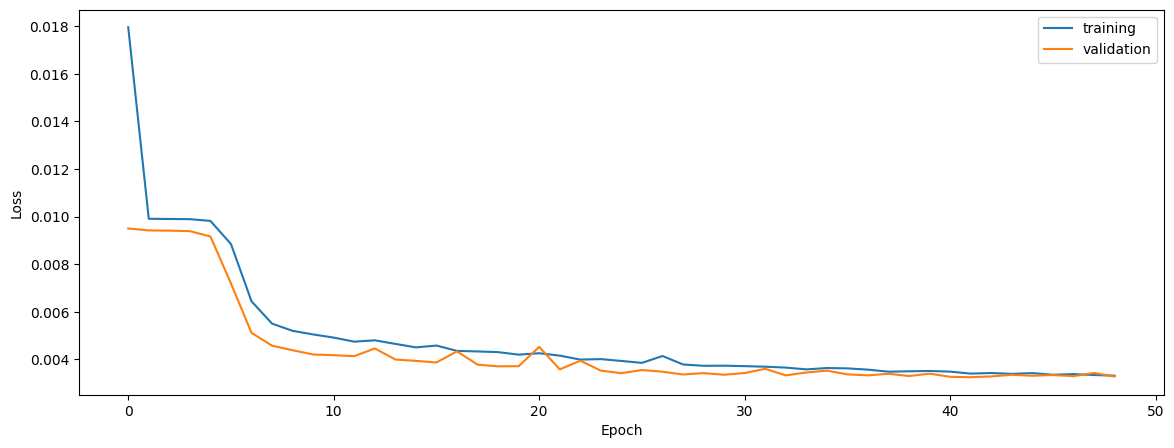

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8143790319772368
0.8100881461789275
0.7897246771845874


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.8132165587375803
0.8081246309411864
0.7969940208860535


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.8158859496704511
0.8082494914941121
0.8026159169869653


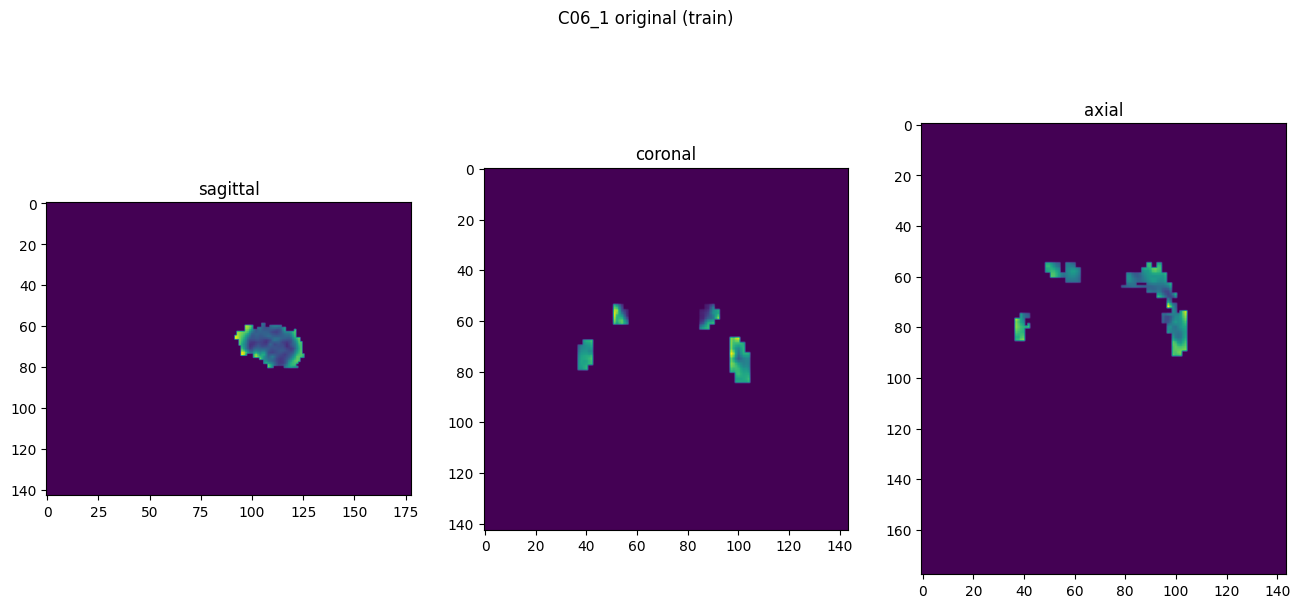

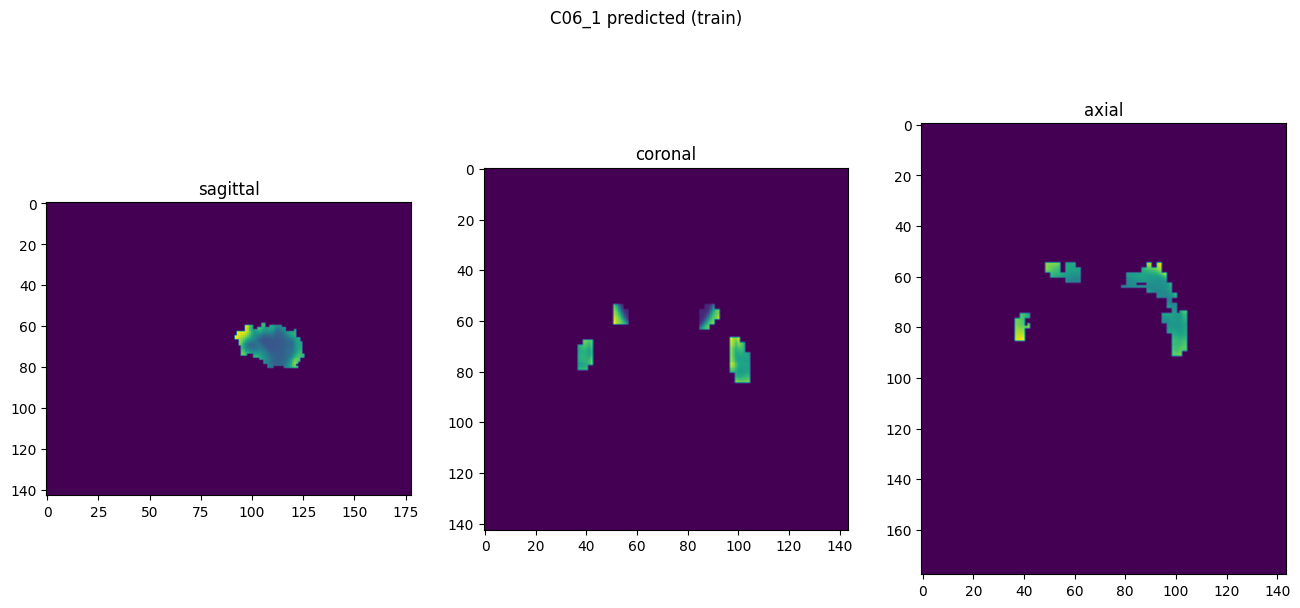

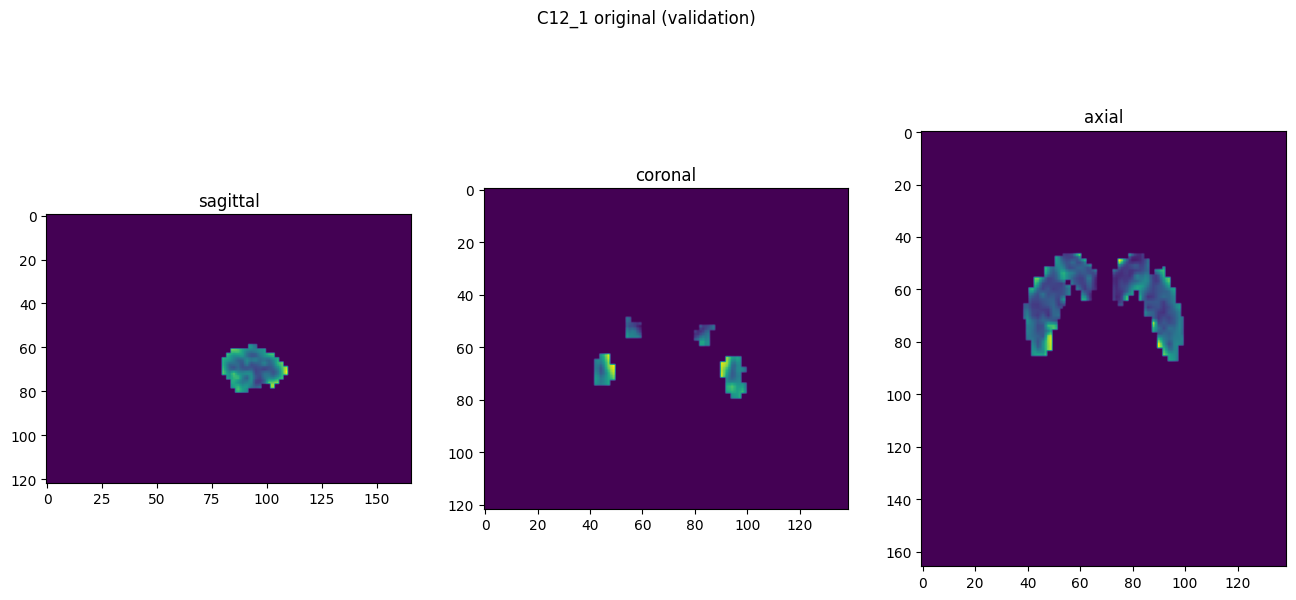

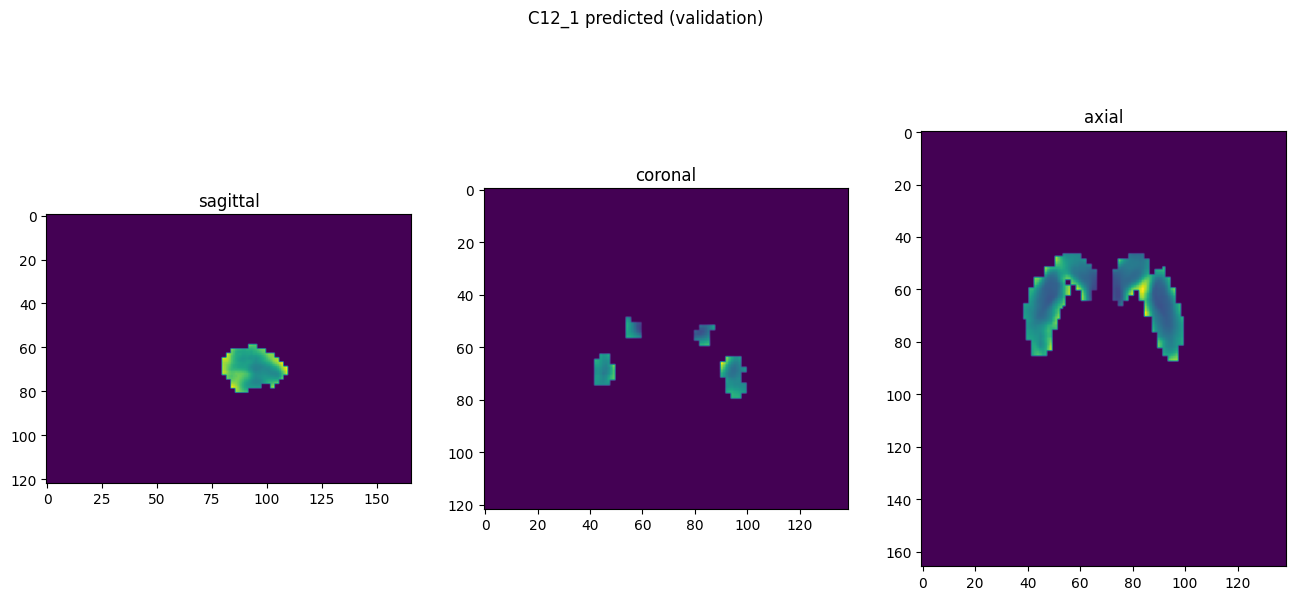

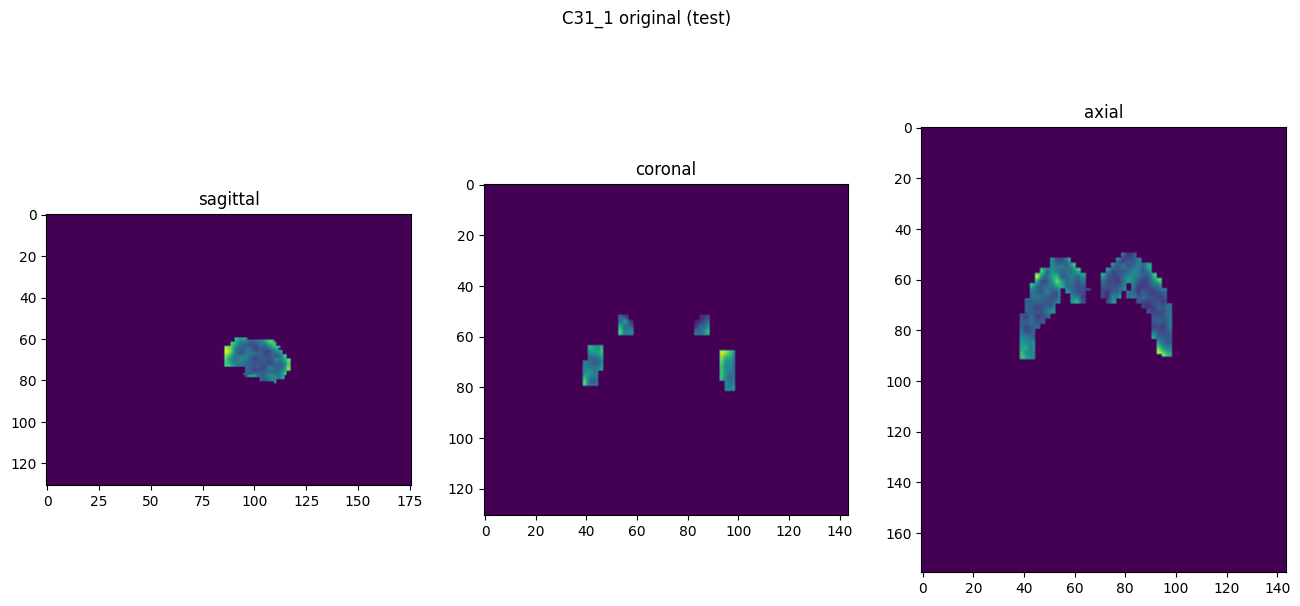

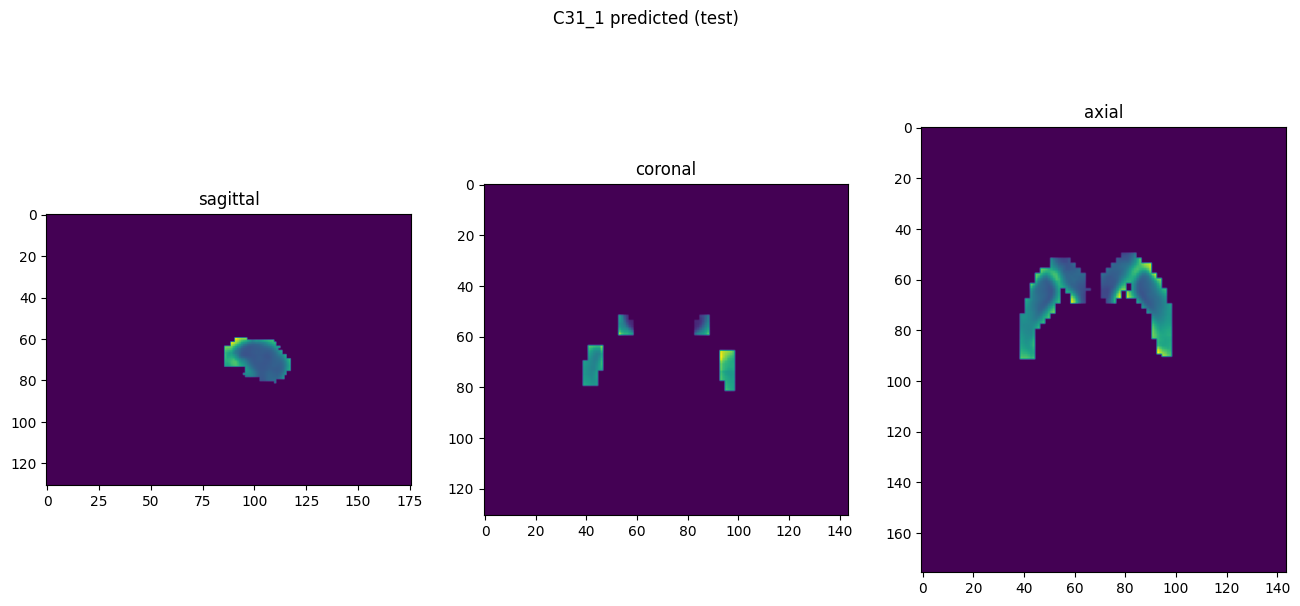

In [10]:
showResults(model, gen, threshold=None, background=False)